# Importing data from EuroStat with SDMX package

Import the library and create the "object" that will manage the connection to the server of the data provider.

In [1]:
import sdmx
estat = sdmx.Client("ESTAT")

Get a datastructure, which is a structured piece of message that contains the data definition for a given datastructure.
Essentially, it contains a description of the dimensions of the datastructure.

In [2]:
sm = estat.datastructure("PRC_HICP_MIDX")
sm

<sdmx.StructureMessage>
  <Header>
    id: 'DSD1726650011'
    prepared: '2024-09-18T09:00:11.295000+00:00'
    sender: <Agency ESTAT>
    source: 
    test: False
  response: <Response [200]>
  Codelist (5): FREQ UNIT COICOP GEO OBS_FLAG
  ConceptScheme (1): PRC_HICP_MIDX
  DataStructureDefinition (1): PRC_HICP_MIDX

Now get the descriptions of what "units" are available (or what frequencies for instance, or geographies...)

In [3]:
# this gets the series of the units with a description basically
units = sdmx.to_pandas(sm.get("UNIT"))
units

UNIT
TOTAL                                                    Total
NR                                                      Number
NR_HAB                                   Number per inhabitant
THS                                                   Thousand
MIO                                                    Million
                                   ...                        
PYR_MNAC     Previous year replacement costs, million units...
EB                                                     Exabyte
PC_RWA                      Percentage of risk-weighted assets
CID_A_AVG    Annual average core inflation differential (ov...
CID_EA       Core inflation differential vis-à-vis the euro...
Name: Unit of measure, Length: 743, dtype: object

After an initial exploration, I already know that one of the available "units" for what you are after is "I05" which is the rebasing of the metric to 100 in 2005. Another one is I96 for instance... you can use or not one or more keys when getting the data and each key can have multiple values.
You may already know this from browsing the interface of the Eurostat website and you may already know the codes you are after.
Note that here I only choose 1 unit, but I could have specified (see the sdmx package documentation) more than 1 unit by using a list or a string with + as separators: 

... "unit": ["I05","I96"]
... "unit": "I05+I96"

In [4]:
dm = estat.data(
    "PRC_HICP_MIDX",
    key={"geo": "EA", "unit": "I05+I96"},
    params={"startPeriod": "2013"},
)

In [5]:
data = sdmx.to_pandas(dm)
data.info()

<class 'pandas.core.series.Series'>
MultiIndex: 42000 entries, ('M', 'I05', 'CP00', 'EA', '2013-01') to ('M', 'I96', 'TOT_X_HOUS', 'EA', '2024-08')
Series name: value
Non-Null Count  Dtype  
--------------  -----  
42000 non-null  float64
dtypes: float64(1)
memory usage: 626.4+ KB


In [6]:
data

freq  unit  coicop      geo  TIME_PERIOD
M     I05   CP00        EA   2013-01        115.67
                             2013-02        116.10
                             2013-03        117.47
                             2013-04        117.37
                             2013-05        117.49
                                             ...  
      I96   TOT_X_HOUS  EA   2024-04        168.90
                             2024-05        169.30
                             2024-06        169.70
                             2024-07        169.50
                             2024-08        169.70
Name: value, Length: 42000, dtype: float64

You can see that the above is a pandas series with a MultiIndex index.
A MultiIndex index is essentially an index with multiple levels that index the data, and as you can see there are units of I05 and I96 because I requested both, but there is only a single geography. There is also a single a single available frequency (M).
You can also verify this by exploring the levels of the MultiIndex.
The level of the MultiIndex called "coicop" is the most complex one and you'll know better than me what that is about... with all the descriptions of the different datasets.

In [7]:
type(data)

pandas.core.series.Series

In [8]:
type(data.index)

pandas.core.indexes.multi.MultiIndex

In [9]:
data.index.levels[0]

Index(['M'], dtype='object', name='freq')

In [10]:
data.index.levels[1]

Index(['I05', 'I96'], dtype='object', name='unit')

In [11]:
data.index.levels[2]

Index(['CP00', 'CP01', 'CP011', 'CP0111', 'CP0112', 'CP0113', 'CP0114',
       'CP0115', 'CP0116', 'CP0117',
       ...
       'TOT_X_EDUC_HLTH_SPR', 'TOT_X_FOOD_S', 'TOT_X_FROOPP', 'TOT_X_FUEL',
       'TOT_X_HOUS', 'TOT_X_NRG', 'TOT_X_NRG_FOOD', 'TOT_X_NRG_FOOD_NP',
       'TOT_X_NRG_FOOD_S', 'TOT_X_TBC'],
      dtype='object', name='coicop', length=166)

In [12]:
data.index.levels[3]

Index(['EA'], dtype='object', name='geo')

To access a single level of the MultiIndex for instance you can use an index slice from pandas.
So to get ALL the series based to 2005 and for the EA area... you select this and Pandas will extract the dataset for you and will "squeeze" out the dimensions when needed in the MultiIndex. Now from a MultiIndex with 4 levels you are down to a MultiIndex with 2 levels.
At that point for instance you can "unstack" the series and turn the level of the "coicop" to columns (just an example of what can be done quickly).

In [13]:
import pandas as pd
data_simplified = data.loc[pd.IndexSlice["M","I05",:,"EA"]]
data_simplified

coicop     TIME_PERIOD
CP00       2013-01        115.67
           2013-02        116.10
           2013-03        117.47
           2013-04        117.37
           2013-05        117.49
                           ...  
TOT_X_TBC  2024-04        147.17
           2024-05        147.49
           2024-06        147.77
           2024-07        147.70
           2024-08        147.89
Name: value, Length: 23240, dtype: float64

In [14]:
data_as_df = data_simplified.unstack(level=0)
data_as_df

coicop,CP00,CP01,CP011,CP0111,CP0112,CP0113,CP0114,CP0115,CP0116,CP0117,...,TOT_X_EDUC_HLTH_SPR,TOT_X_FOOD_S,TOT_X_FROOPP,TOT_X_FUEL,TOT_X_HOUS,TOT_X_NRG,TOT_X_NRG_FOOD,TOT_X_NRG_FOOD_NP,TOT_X_NRG_FOOD_S,TOT_X_TBC
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,
2013-01,115.67,119.32,119.35,122.30,119.59,120.35,117.32,119.36,118.55,121.23,...,115.75,115.50,111.16,114.03,113.45,112.53,110.16,111.88,112.20,115.13
2013-02,116.10,119.41,119.46,122.63,119.61,119.31,117.48,120.06,119.40,120.89,...,116.19,115.95,111.55,114.32,113.90,112.83,110.50,112.22,112.52,115.56
2013-03,117.47,119.77,119.84,122.67,119.63,119.38,117.40,120.62,120.86,122.88,...,117.66,117.33,113.97,115.85,115.52,114.42,112.40,113.89,114.13,116.94
2013-04,117.37,120.04,120.15,122.77,119.68,120.03,117.34,120.96,122.13,123.98,...,117.54,117.18,113.71,115.82,115.47,114.45,112.37,113.87,114.11,116.83
2013-05,117.49,120.82,121.03,122.90,119.80,119.83,117.79,122.46,129.15,125.05,...,117.67,117.21,113.91,116.10,115.65,114.76,112.59,114.09,114.32,116.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04,148.65,166.06,166.99,165.54,161.86,172.05,164.17,229.66,173.58,175.55,...,149.84,147.84,139.30,147.22,144.49,143.09,135.85,141.46,142.01,147.17
2024-05,148.97,166.39,167.37,165.62,162.02,172.26,164.05,229.57,176.88,175.67,...,150.13,148.14,139.84,147.73,144.88,143.63,136.43,141.98,142.53,147.49
2024-06,149.29,166.49,167.44,165.93,162.08,171.77,164.19,230.05,177.43,174.64,...,150.44,148.49,140.40,148.21,145.17,144.09,136.92,142.49,143.03,147.77


Also note that the SDMX does not define that "dates" are to be treated as dates... i.e. the Index of the above DataFrame is a simple Index and with dtype of "object" and is not a DatetimeIndex which is more appropriate for data analysis in time series domain. You can easily transform this in different ways but one is to "reassign" the index of the DataFrame to a new value, which is a new index created with the old index data converted automatically to datetime.

In [15]:
data_as_df.index

Index(['2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06',
       '2013-07', '2013-08', '2013-09', '2013-10',
       ...
       '2023-11', '2023-12', '2024-01', '2024-02', '2024-03', '2024-04',
       '2024-05', '2024-06', '2024-07', '2024-08'],
      dtype='object', name='TIME_PERIOD', length=140)

In [16]:
# you could in theory assign this directly to the original property index
# but here i show how the datatype of the index has changed. Pandas DatetimeIndex 
# creation function (first line below) is able to see that the string format yyyy-mm 
# is to be interpreted as a date. To specify that it has to be interpreted as end of month
# though instead of a beginning of month (which would be the default interpretation if the
# day is missing you can then add the offset that brings you to month end. To further clarify
# this i also set the frequency to the correct and compatible frequency (Month End)
new_idx = pd.DatetimeIndex(data_as_df.index.to_numpy(), name="period") + pd.offsets.MonthEnd()
new_idx.freq = "ME"
new_idx

DatetimeIndex(['2013-01-31', '2013-02-28', '2013-03-31', '2013-04-30',
               '2013-05-31', '2013-06-30', '2013-07-31', '2013-08-31',
               '2013-09-30', '2013-10-31',
               ...
               '2023-11-30', '2023-12-31', '2024-01-31', '2024-02-29',
               '2024-03-31', '2024-04-30', '2024-05-31', '2024-06-30',
               '2024-07-31', '2024-08-31'],
              dtype='datetime64[ns]', name='period', length=140, freq='ME')

Now set the index to the DataFrame

In [17]:
data_as_df.index = new_idx
data_as_df

coicop,CP00,CP01,CP011,CP0111,CP0112,CP0113,CP0114,CP0115,CP0116,CP0117,...,TOT_X_EDUC_HLTH_SPR,TOT_X_FOOD_S,TOT_X_FROOPP,TOT_X_FUEL,TOT_X_HOUS,TOT_X_NRG,TOT_X_NRG_FOOD,TOT_X_NRG_FOOD_NP,TOT_X_NRG_FOOD_S,TOT_X_TBC
period,,,,,,,,,,,,,,,,,,,,,
2013-01-31,115.67,119.32,119.35,122.30,119.59,120.35,117.32,119.36,118.55,121.23,...,115.75,115.50,111.16,114.03,113.45,112.53,110.16,111.88,112.20,115.13
2013-02-28,116.10,119.41,119.46,122.63,119.61,119.31,117.48,120.06,119.40,120.89,...,116.19,115.95,111.55,114.32,113.90,112.83,110.50,112.22,112.52,115.56
2013-03-31,117.47,119.77,119.84,122.67,119.63,119.38,117.40,120.62,120.86,122.88,...,117.66,117.33,113.97,115.85,115.52,114.42,112.40,113.89,114.13,116.94
2013-04-30,117.37,120.04,120.15,122.77,119.68,120.03,117.34,120.96,122.13,123.98,...,117.54,117.18,113.71,115.82,115.47,114.45,112.37,113.87,114.11,116.83
2013-05-31,117.49,120.82,121.03,122.90,119.80,119.83,117.79,122.46,129.15,125.05,...,117.67,117.21,113.91,116.10,115.65,114.76,112.59,114.09,114.32,116.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30,148.65,166.06,166.99,165.54,161.86,172.05,164.17,229.66,173.58,175.55,...,149.84,147.84,139.30,147.22,144.49,143.09,135.85,141.46,142.01,147.17
2024-05-31,148.97,166.39,167.37,165.62,162.02,172.26,164.05,229.57,176.88,175.67,...,150.13,148.14,139.84,147.73,144.88,143.63,136.43,141.98,142.53,147.49
2024-06-30,149.29,166.49,167.44,165.93,162.08,171.77,164.19,230.05,177.43,174.64,...,150.44,148.49,140.40,148.21,145.17,144.09,136.92,142.49,143.03,147.77


Create a YoY change... as this is monthly it's easy.

In [18]:
yoy_cpi = data_as_df.pct_change(12) * 100

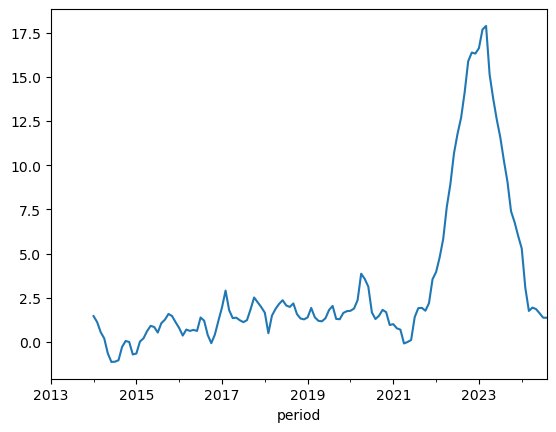

In [19]:
ax = yoy_cpi["CP011"].plot()